<a href="https://colab.research.google.com/github/J1ngtin9/Jingting_project/blob/main/code/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q snownlp


In [ ]:
import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from snownlp import SnowNLP


In [ ]:

# ------------------
# Parameters
# ------------------
INPUT_XLSX   = "Newspapers_merged_sorted.xlsx"
OUT_XLSX     = "EDA_and_basic_sentiment.xlsx"
SHE_REGEX    = r"(她)"   # subset: titles that explicitly contain "她..."
NEUTRAL_BAND = 0.05               # neutral band around 0.5 for labeling
TOP_N_PAPERS = 20                 # top-N newspapers by count to display

In [ ]:
# ------------------
# Load data
# ------------------
df = pd.read_excel(INPUT_XLSX)
if "Title" not in df.columns:
    raise ValueError("Column `Title` not found in the input Excel file.")

df["Title"] = df["Title"].astype(str).str.strip()
# Derive year from Time if present (coerce errors to NaT)
df["year"]  = pd.to_datetime(df.get("Time"), errors="coerce").dt.year

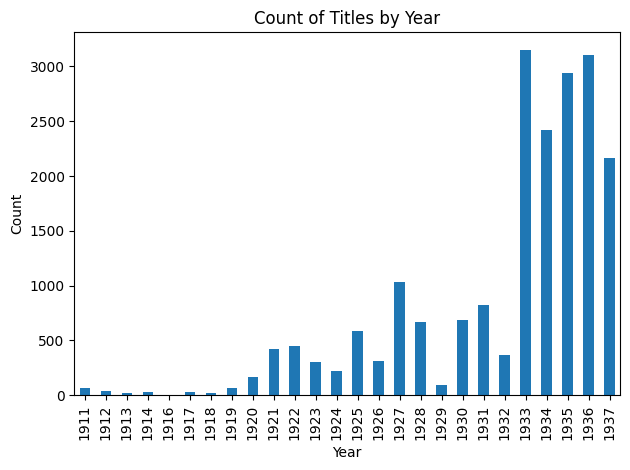

In [ ]:
# ------------------
# 1) Year bar chart
# ------------------
year_counts = (
    df["year"]
    .value_counts(dropna=False)
    .sort_index()
    .rename("count")
    .to_frame()
)

plt.figure()
year_counts["count"].plot(kind="bar")
plt.title("Count of Titles by Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [ ]:

# ------------------
# Show the first 10 titles (as they appear in the file)
# ------------------
top10_all = df["Title"].head(10).reset_index(drop=True)
print("\n[Top 10 titles overall]")
for i, t in enumerate(top10_all, 1):
    print(f"{i:>2}. {t}")



[Top 10 titles overall]
 1. 野史氏辨狱丛谈
 2. 政党组织之必要
 3. 论大隈伯对待淸国谈之谬妄（续昨）
 4. 学部注最小学教育
 5. 幸未成灾
 6. 今日是中西医大决战之时机
 7. [T]我知道色字当戒然而我在南京路福州路一带见一般艳妆妇女……
 8. 折衷社之反对论
 9. 焕然一新
10. 试行新币法


/tmp/ipython-input-2301376409.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df["has_she_in_title"] = df["Title"].str.contains(SHE_REGEX, na=False)
/tmp/ipython-input-2301376409.py:19: UserWarning: Glyph 22905 (\N{CJK UNIFIED IDEOGRAPH-5979}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22905 (\N{CJK UNIFIED IDEOGRAPH-5979}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


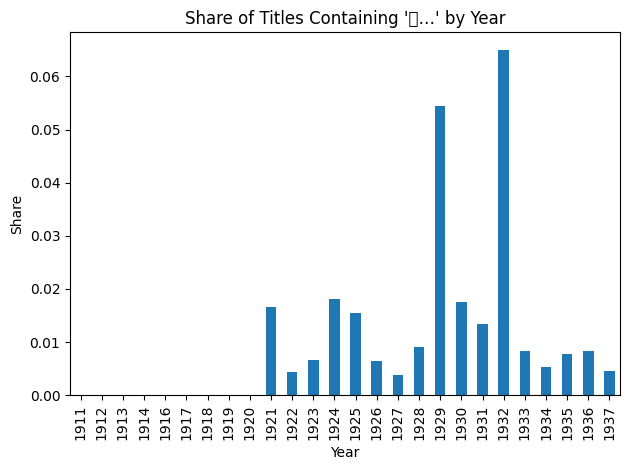

In [ ]:
# -----------------------------------------------------
# 3) Share of titles containing "她" (overview)
# -----------------------------------------------------
df["has_she_in_title"] = df["Title"].str.contains(SHE_REGEX, na=False)
share_overall = float(df["has_she_in_title"].mean())

she_by_year = (
    df.groupby("year")["has_she_in_title"]
      .mean()
      .rename("share_with_she")
      .to_frame()
)

plt.figure()
she_by_year["share_with_she"].plot(kind="bar")
plt.title("Share of Titles Containing 'She' by Year")
plt.xlabel("Year")
plt.ylabel("Share")
plt.tight_layout()
plt.show()


In [ ]:
# ------------------
# Show the first 10 titles that contain the single character "她"
# (sorted by year, then by title for readability)
# ------------------
hits = df[df["Title"].str.contains("她", na=False)].copy()
hits = hits.sort_values(["year", "Title"], na_position="last")

# choose a few helpful columns if they exist
cols_wanted = ["Title", "year", "Newspaper Title", "Time", "SourceFile"]
cols = [c for c in cols_wanted if c in hits.columns]

print("\n[Top 10 titles containing '她']")
print(hits[cols].head(10).to_string(index=False))



[Top 10 titles containing '她']
          Title  year Newspaper Title       Time       SourceFile
代名词他（He）同她（She）  1921              晨报 1921-03-18 Newspaper/10.txt
              她  1921              晨报 1921-04-23 Newspaper/12.txt
              她  1921              京报 1921-06-09 Newspaper/13.txt
          她最后的话  1921              京报 1921-03-23 Newspaper/10.txt
           她的一生  1921              京报 1921-03-15 Newspaper/10.txt
        她的一生（续）  1921              京报 1921-03-16 Newspaper/10.txt
           她的去时  1921              晨报 1921-09-27 Newspaper/16.txt
            他和她  1922              京报 1922-03-28 Newspaper/18.txt
           她的恋爱  1922              京报 1922-10-23 Newspaper/25.txt
  发行边藏劝她债劵之官样文章  1923              京报 1923-05-10 Newspaper/28.txt


In [ ]:
# ------------------
# 4) SnowNLP sentiment
# ------------------
def snow_score(text: str) -> float:
    """
    Return SnowNLP sentiment in [0,1]; higher = more positive.
    Returns NaN for empty or non-string inputs.
    """
    if not isinstance(text, str) or not text.strip():
        return np.nan
    try:
        return float(SnowNLP(text).sentiments)
    except Exception:
        return np.nan

def label_from_posprob(p: float, band: float = NEUTRAL_BAND) -> str:
    """
    Convert a positive-probability (0..1) into a label with a neutral band.
    >= 0.5 + band -> positive; <= 0.5 - band -> negative; else neutral.
    """
    if pd.isna(p):
        return "neutral"
    if p >= 0.5 + band:
        return "positive"
    if p <= 0.5 - band:
        return "negative"
    return "neutral"

# Score ALL titles
print("[INFO] Scoring ALL titles (SnowNLP)…")
df["pos_score_all"] = [snow_score(t) for t in tqdm(df["Title"].fillna("").tolist())]
df["sent_all"] = df["pos_score_all"].apply(label_from_posprob)

# Score only titles that explicitly contain "她…"
df_she = df[df["has_she_in_title"]].copy()
print("[INFO] Scoring SHE-subset titles (SnowNLP)…")
df_she["pos_score_title_she"] = [snow_score(t) for t in tqdm(df_she["Title"].fillna("").tolist())]
df_she["sent_title_she"] = df_she["pos_score_title_she"].apply(label_from_posprob)

[INFO] Scoring ALL titles (SnowNLP)…


  0%|          | 0/20177 [00:00<?, ?it/s]

[INFO] Scoring SHE-subset titles (SnowNLP)…


  0%|          | 0/186 [00:00<?, ?it/s]

In [ ]:
# ------------------
# Summaries & yearly breakdowns
# ------------------
def summarize(series: pd.Series) -> pd.Series:
    """
    Summarize counts and positive rate for a label series with values in {positive, neutral, negative}.
    """
    vc = series.value_counts()
    n   = int(vc.sum())
    pos = int(vc.get("positive", 0))
    neg = int(vc.get("negative", 0))
    neu = int(vc.get("neutral",  0))
    pos_rate = pos / n if n else np.nan
    return pd.Series({"n": n, "positive": pos, "negative": neg, "neutral": neu, "pos_rate": pos_rate})

sum_all = summarize(df["sent_all"])
sum_she = summarize(df_she["sent_title_she"])

all_by_year = df.groupby("year")["sent_all"].value_counts().unstack(fill_value=0).sort_index()
she_by_year_sent = df_she.groupby("year")["sent_title_she"].value_counts().unstack(fill_value=0).sort_index()

print("\n[ALL] Overall sentiment counts/rates:\n", sum_all)
print("\n[SHE] Sentiment for titles containing 'She':\n", sum_she)


[ALL] Overall sentiment counts/rates:
 n           20177.000000
positive    12273.000000
negative     4489.000000
neutral      3415.000000
pos_rate        0.608267
dtype: float64

[SHE] Sentiment for titles containing 'She':
 n           186.000000
positive    113.000000
negative     37.000000
neutral      36.000000
pos_rate      0.607527
dtype: float64


<Figure size 640x480 with 0 Axes>

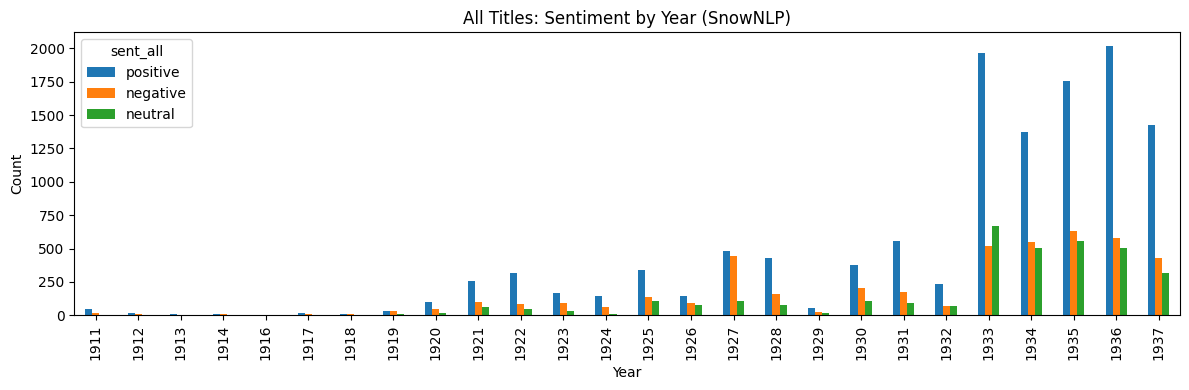

<Figure size 640x480 with 0 Axes>

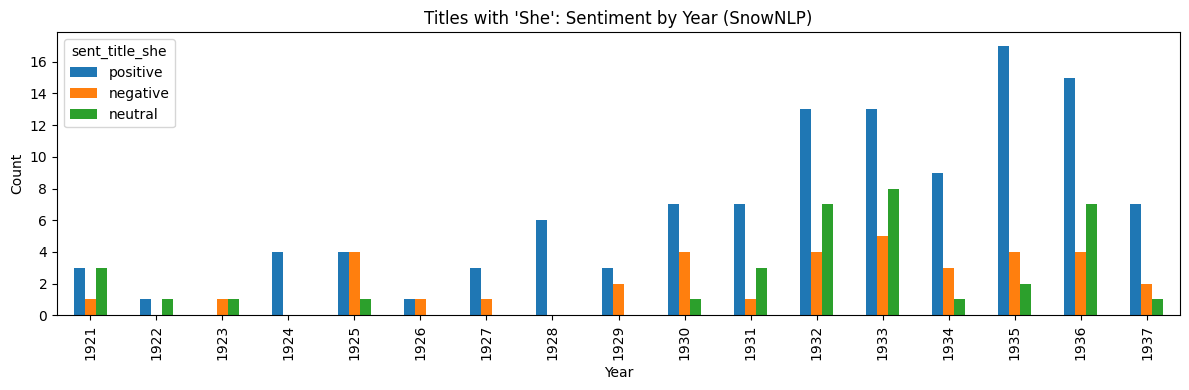

In [ ]:
# ------------------
# Charts: yearly sentiment distributions
# ------------------
if not all_by_year.empty:
    plt.figure()
    (all_by_year[["positive","negative","neutral"]]
     .plot(kind="bar", figsize=(12,4)))
    plt.title("All Titles: Sentiment by Year (SnowNLP)")
    plt.xlabel("Year")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

if not she_by_year_sent.empty:
    plt.figure()
    (she_by_year_sent[["positive","negative","neutral"]]
     .plot(kind="bar", figsize=(12,4)))
    plt.title("Titles with 'She': Sentiment by Year (SnowNLP)")
    plt.xlabel("Year")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()